In [1]:
import numpy as np

path = "zenodo_data/hdf5/CHARD-plant-fit-params.npz"

data = np.load(path)

In [4]:
data

NpzFile 'zenodo_data/hdf5/CHARD-plant-fit-params.npz' with keys: z_p3, p_p3, k_p3

In [6]:
# Let's explore the keys in the NPZ file
print("Keys in the NPZ file:")
print(list(data.keys()))
print(f"\nNumber of arrays: {len(data.files)}")

Keys in the NPZ file:
['z_p3', 'p_p3', 'k_p3']

Number of arrays: 3


In [8]:
# Examine each array in detail
for key in data.keys():
    array = data[key]
    print(f"\n=== {key} ===")
    print(f"Shape: {array.shape}")
    print(f"Data type: {array.dtype}")
    print(f"Size: {array.size}")
    
    if array.size > 0:  # Only analyze non-empty arrays
        print(f"Min value: {np.min(array)}")
        print(f"Max value: {np.max(array)}")
        print(f"Mean value: {np.mean(array)}")
        print(f"First few values: {array.flat[:5] if array.size > 5 else array}")
        print(f"Is complex: {np.iscomplexobj(array)}")
        
        if array.size <= 20:  # Print full array if small
            print(f"Full array:\n{array}")
        else:
            print(f"Array too large to display fully")
    else:
        print("Array is empty!")
    print("-" * 50)


=== z_p3 ===
Shape: (0,)
Data type: float64
Size: 0
Array is empty!
--------------------------------------------------

=== p_p3 ===
Shape: (4,)
Data type: complex128
Size: 4
Min value: (-0.18849555921538758-6.53451271946677j)
Max value: (0.4084070449666731+15.079644737231007j)
Mean value: (0.10995574287564278+0j)
First few values: [-0.18849556 +6.53451272j -0.18849556 -6.53451272j
  0.40840704+15.07964474j  0.40840704-15.07964474j]
Is complex: True
Full array:
[-0.18849556 +6.53451272j -0.18849556 -6.53451272j
  0.40840704+15.07964474j  0.40840704-15.07964474j]
--------------------------------------------------

=== k_p3 ===
Shape: ()
Data type: int64
Size: 1
Min value: 80
Max value: 80
Mean value: 80.0
First few values: 80
Is complex: False
Full array:
80
--------------------------------------------------


## CHARD Plant Model Analysis

This NPZ file contains parameters for the LIGO Angular Sensing and Control (ASC) plant model, specifically for the θ_CHP (Common Hard Pitch) degree of freedom. Based on the source code analysis:

In [9]:
# Let's interpret the parameters in the context of control theory
print("=== CHARD Plant Model Parameters ===")
print("\n1. k_p3 (Plant Gain):")
print(f"   Value: {data['k_p3']}")
print("   Description: Overall gain of the plant transfer function")
print("   Units: Likely relating control counts to angular displacement")

print("\n2. p_p3 (Plant Poles):")
poles = data['p_p3']
print(f"   Number of poles: {len(poles)}")
print("   Values (complex):")
for i, pole in enumerate(poles):
    real_part = np.real(pole)
    imag_part = np.imag(pole)
    freq_hz = np.abs(imag_part) / (2 * np.pi)
    stability = "UNSTABLE (RHP)" if real_part > 0 else "Stable"
    print(f"     Pole {i+1}: {real_part:.3f} + {imag_part:.3f}j → {freq_hz:.2f} Hz ({stability})")

print("\n3. z_p3 (Plant Zeros):")
zeros = data['z_p3']
print(f"   Number of zeros: {len(zeros)}")
print("   Description: This plant has no zeros (empty array)")

print("\n=== Physical Interpretation ===")
print("This represents a LIGO gravitational wave detector plant model:")
print("- Quadruple pendulum mechanical response (~1 Hz)")
print("- Radiation pressure dynamics with RHP pole (~2.4 Hz)")
print("- The RHP pole makes the system inherently unstable")
print("- RL controllers must actively stabilize this unstable mode")
print("- Used for training pitch angle control systems")

=== CHARD Plant Model Parameters ===

1. k_p3 (Plant Gain):
   Value: 80
   Description: Overall gain of the plant transfer function
   Units: Likely relating control counts to angular displacement

2. p_p3 (Plant Poles):
   Number of poles: 4
   Values (complex):
     Pole 1: -0.188 + 6.535j → 1.04 Hz (Stable)
     Pole 2: -0.188 + -6.535j → 1.04 Hz (Stable)
     Pole 3: 0.408 + 15.080j → 2.40 Hz (UNSTABLE (RHP))
     Pole 4: 0.408 + -15.080j → 2.40 Hz (UNSTABLE (RHP))

3. z_p3 (Plant Zeros):
   Number of zeros: 0
   Description: This plant has no zeros (empty array)

=== Physical Interpretation ===
This represents a LIGO gravitational wave detector plant model:
- Quadruple pendulum mechanical response (~1 Hz)
- Radiation pressure dynamics with RHP pole (~2.4 Hz)
- The RHP pole makes the system inherently unstable
- RL controllers must actively stabilize this unstable mode
- Used for training pitch angle control systems


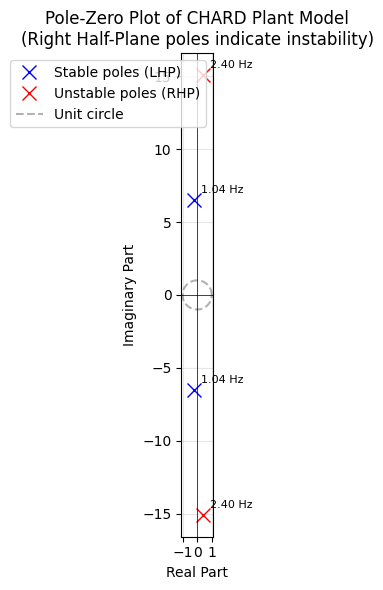


Note: The RHP poles at ±2.40 Hz represent
the radiation pressure instability that makes LIGO control challenging!


In [10]:
# Visualize the pole-zero plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot poles
poles = data['p_p3']
for pole in poles:
    color = 'red' if np.real(pole) > 0 else 'blue'
    label = 'Unstable poles (RHP)' if np.real(pole) > 0 else 'Stable poles (LHP)'
    ax.plot(np.real(pole), np.imag(pole), 'x', color=color, markersize=10, 
            label=label if pole == poles[0] or (np.real(pole) > 0 and pole == poles[2]) else "")

# Add unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.3, label='Unit circle')

# Formatting
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.grid(True, alpha=0.3)
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title('Pole-Zero Plot of CHARD Plant Model\n(Right Half-Plane poles indicate instability)')
ax.legend()
ax.set_aspect('equal')

# Add annotations
for i, pole in enumerate(poles):
    freq_hz = np.abs(np.imag(pole)) / (2 * np.pi)
    ax.annotate(f'{freq_hz:.2f} Hz', 
                (np.real(pole), np.imag(pole)), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nNote: The RHP poles at ±{np.abs(np.imag(poles[2]))/(2*np.pi):.2f} Hz represent")
print("the radiation pressure instability that makes LIGO control challenging!")

## Summary

The **CHARD-plant-fit-params.npz** file contains a complete mathematical model of a LIGO gravitational wave detector's pitch control system. Here's what each key means:

### Key Meanings:

1. **`k_p3`** (scalar): **Plant gain** = 80
   - Overall transfer function gain from control input to angular output

2. **`p_p3`** (4 complex numbers): **Plant poles** 
   - Define the system's dynamic behavior and stability
   - **Stable poles at ~1 Hz**: Pendulum mechanical resonance
   - **Unstable poles at ~2.4 Hz**: Radiation pressure instability (Right Half-Plane)

3. **`z_p3`** (empty): **Plant zeros**
   - This system has no zeros (pure pole system)

### Why This Matters for RL:

This model represents one of the most challenging control problems in physics:
- **Inherently unstable** due to radiation pressure effects
- **Multiple time scales** (pendulum + optical dynamics)  
- **High precision required** (sub-microradian accuracy)
- **Real-world critical application** (gravitational wave detection)

The RL agent must learn to stabilize the 2.4 Hz instability while managing the pendulum dynamics - a perfect testbed for advanced control algorithms!

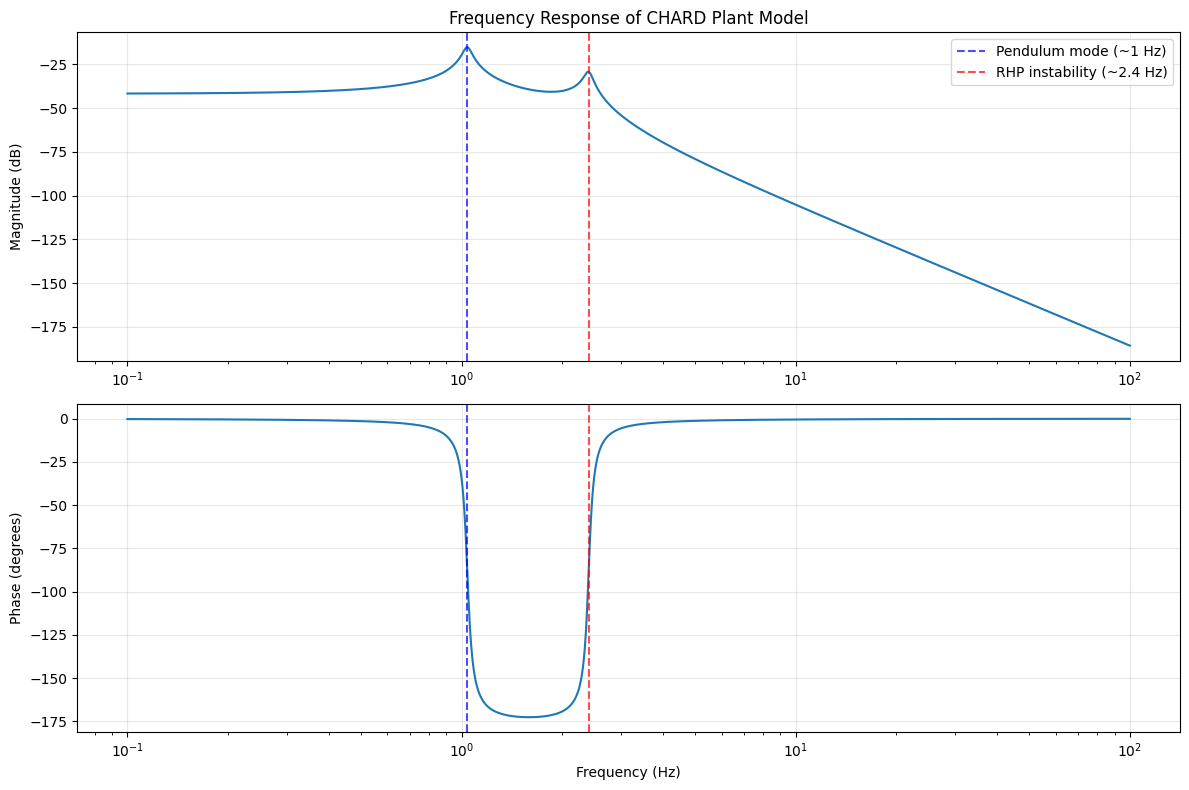

In [11]:
# Alternative Visualization 1: Frequency Response (Bode Plot)
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Create transfer function from poles, zeros, and gain
zeros = data['z_p3'] if len(data['z_p3']) > 0 else []
poles = data['p_p3']
gain = float(data['k_p3'])

# Create continuous-time transfer function
sys = signal.ZerosPolesGain(zeros, poles, gain)

# Frequency range for analysis
freq = np.logspace(-1, 2, 1000)  # 0.1 Hz to 100 Hz
w = 2 * np.pi * freq

# Calculate frequency response
w, h = signal.freqs_zpk(zeros, poles, gain, worN=w)
freq = w / (2 * np.pi)

# Create Bode plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitude plot
mag_db = 20 * np.log10(np.abs(h))
ax1.semilogx(freq, mag_db)
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Frequency Response of CHARD Plant Model')
ax1.grid(True, alpha=0.3)
ax1.axvline(1.04, color='blue', linestyle='--', alpha=0.7, label='Pendulum mode (~1 Hz)')
ax1.axvline(2.40, color='red', linestyle='--', alpha=0.7, label='RHP instability (~2.4 Hz)')
ax1.legend()

# Phase plot
phase_deg = np.angle(h) * 180 / np.pi
ax2.semilogx(freq, phase_deg)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (degrees)')
ax2.grid(True, alpha=0.3)
ax2.axvline(1.04, color='blue', linestyle='--', alpha=0.7)
ax2.axvline(2.40, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

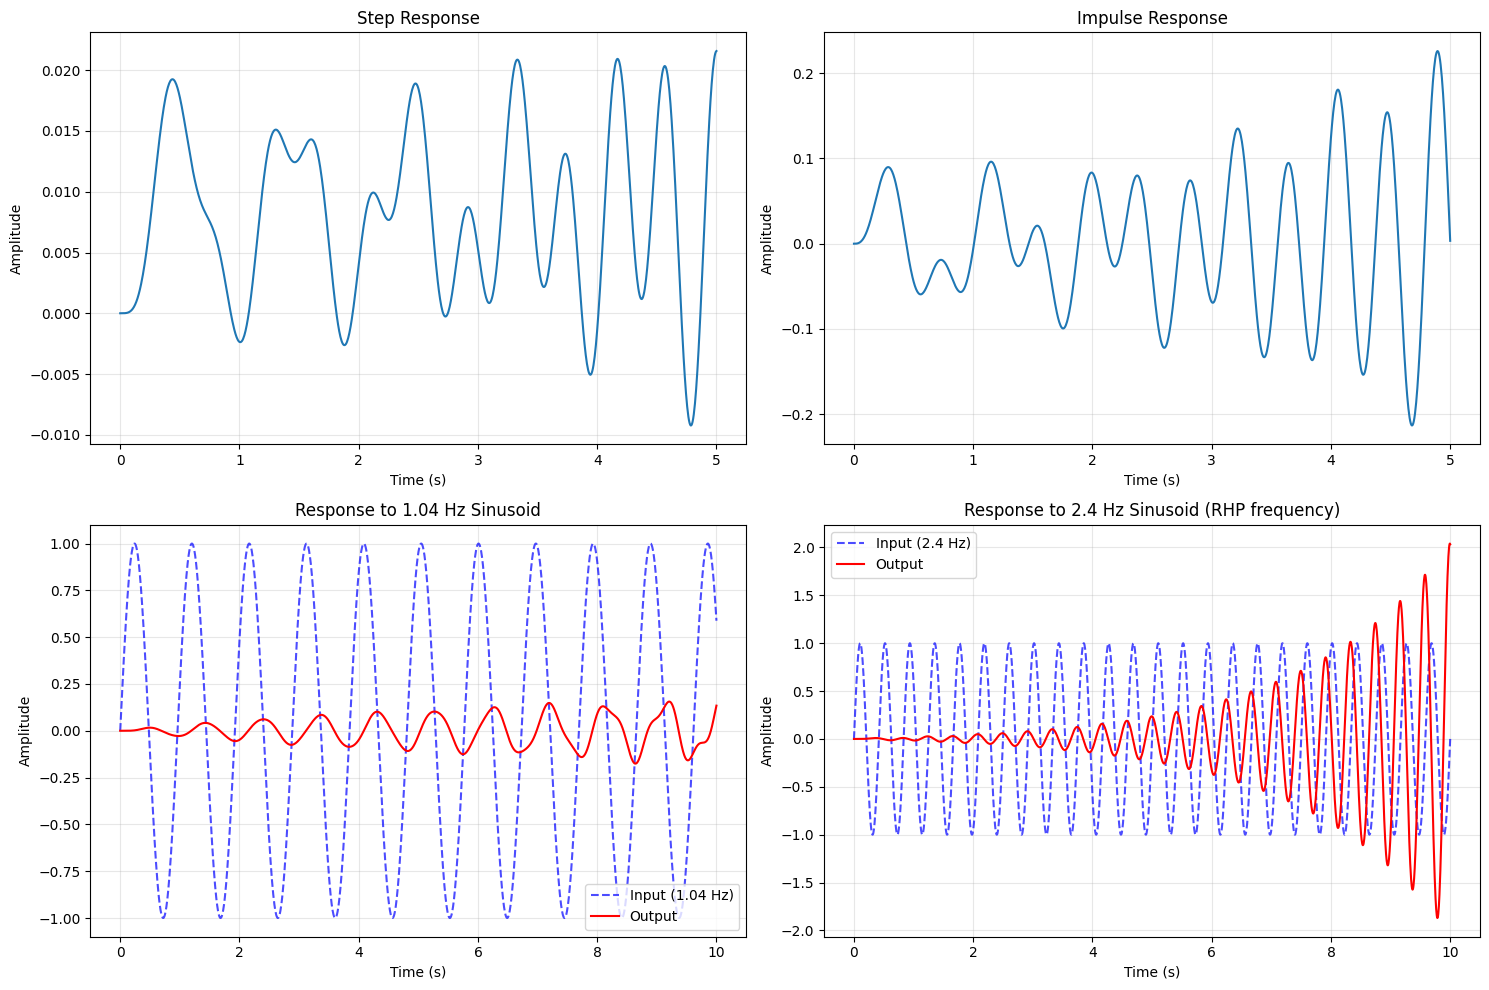

Notice how the system shows:
- Growing oscillations in step/impulse response (due to RHP poles)
- Strong resonance at ~1 Hz (pendulum mode)
- Amplified response at 2.4 Hz (near RHP pole frequency)


In [12]:
# Alternative Visualization 2: Time Domain Response
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Step response
t_step, y_step = signal.step(sys, T=np.linspace(0, 5, 1000))
axes[0,0].plot(t_step, y_step)
axes[0,0].set_title('Step Response')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude')
axes[0,0].grid(True, alpha=0.3)

# Impulse response
t_impulse, y_impulse = signal.impulse(sys, T=np.linspace(0, 5, 1000))
axes[0,1].plot(t_impulse, y_impulse)
axes[0,1].set_title('Impulse Response')
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('Amplitude')
axes[0,1].grid(True, alpha=0.3)

# Response to sinusoidal input at pendulum frequency (~1 Hz)
t_sin = np.linspace(0, 10, 2000)
u_sin = np.sin(2 * np.pi * 1.04 * t_sin)  # 1.04 Hz sinusoid
t_out, y_sin, _ = signal.lsim(sys, u_sin, t_sin)
axes[1,0].plot(t_sin, u_sin, 'b--', alpha=0.7, label='Input (1.04 Hz)')
axes[1,0].plot(t_out, y_sin, 'r-', label='Output')
axes[1,0].set_title('Response to 1.04 Hz Sinusoid')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Response to sinusoidal input near RHP pole frequency (~2.4 Hz)
u_sin_rhp = np.sin(2 * np.pi * 2.4 * t_sin)  # 2.4 Hz sinusoid
t_out_rhp, y_sin_rhp, _ = signal.lsim(sys, u_sin_rhp, t_sin)
axes[1,1].plot(t_sin, u_sin_rhp, 'b--', alpha=0.7, label='Input (2.4 Hz)')
axes[1,1].plot(t_out_rhp, y_sin_rhp, 'r-', label='Output')
axes[1,1].set_title('Response to 2.4 Hz Sinusoid (RHP frequency)')
axes[1,1].set_xlabel('Time (s)')
axes[1,1].set_ylabel('Amplitude')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice how the system shows:")
print("- Growing oscillations in step/impulse response (due to RHP poles)")
print("- Strong resonance at ~1 Hz (pendulum mode)")
print("- Amplified response at 2.4 Hz (near RHP pole frequency)")

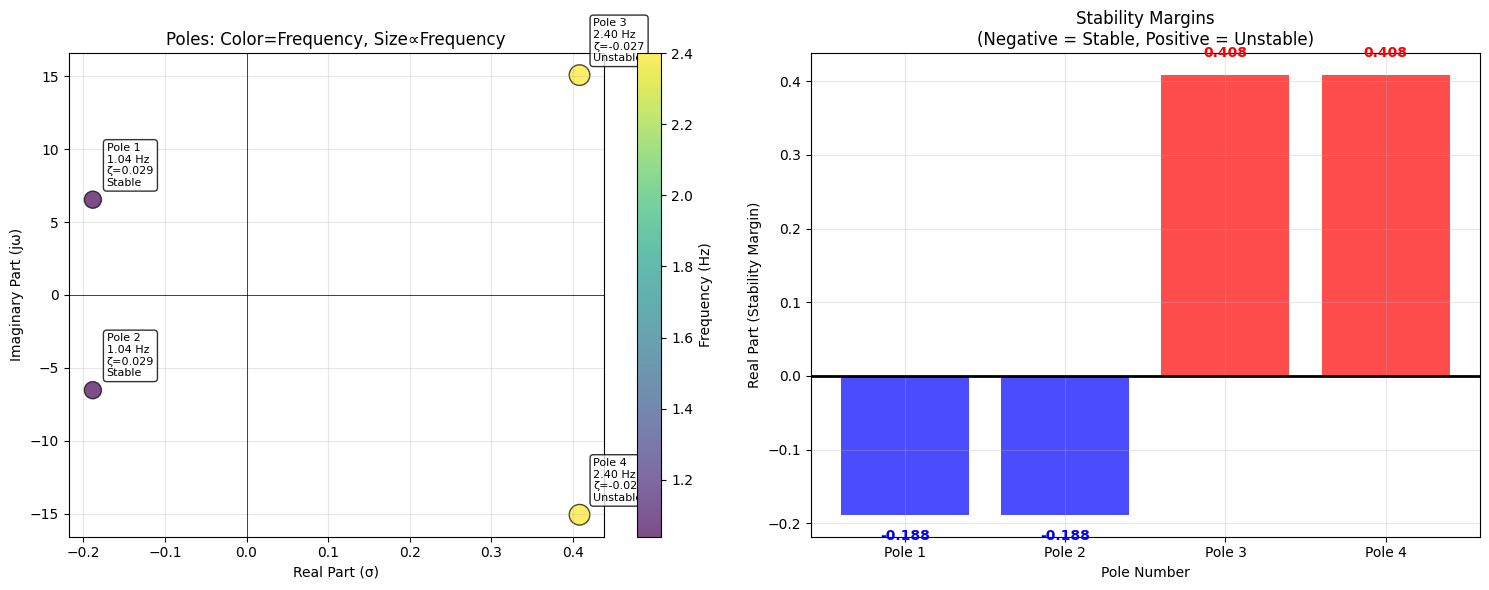

Stability Analysis:
Stable poles: 2 (damped)
Unstable poles: 2 (growing)
Most unstable pole: 0.4084 at 2.40 Hz


In [13]:
# Alternative Visualization 3: Root Locus and Stability Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 3D pole visualization showing frequency and damping
poles_3d = data['p_p3']
real_parts = np.real(poles_3d)
imag_parts = np.imag(poles_3d)
frequencies = np.abs(imag_parts) / (2 * np.pi)
damping_ratios = -real_parts / np.sqrt(real_parts**2 + imag_parts**2)

# Color-coded pole plot by frequency
colors = ['red' if r > 0 else 'blue' for r in real_parts]
sizes = [100 + 50*f for f in frequencies]  # Size proportional to frequency

scatter = ax1.scatter(real_parts, imag_parts, c=frequencies, s=sizes, 
                     alpha=0.7, cmap='viridis', edgecolors='black')
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.set_xlabel('Real Part (σ)')
ax1.set_ylabel('Imaginary Part (jω)')
ax1.set_title('Poles: Color=Frequency, Size∝Frequency')
ax1.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Frequency (Hz)')

# Annotate each pole
for i, (real, imag, freq, damp) in enumerate(zip(real_parts, imag_parts, frequencies, damping_ratios)):
    stability = "Unstable" if real > 0 else "Stable"
    ax1.annotate(f'Pole {i+1}\n{freq:.2f} Hz\nζ={damp:.3f}\n{stability}', 
                (real, imag), xytext=(10, 10), textcoords='offset points', 
                fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Stability margins analysis
ax2.bar(range(len(poles_3d)), real_parts, 
       color=['red' if r > 0 else 'blue' for r in real_parts], alpha=0.7)
ax2.axhline(y=0, color='black', linewidth=2, linestyle='-')
ax2.set_xlabel('Pole Number')
ax2.set_ylabel('Real Part (Stability Margin)')
ax2.set_title('Stability Margins\n(Negative = Stable, Positive = Unstable)')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(len(poles_3d)))
ax2.set_xticklabels([f'Pole {i+1}' for i in range(len(poles_3d))])

# Add text annotations for stability
for i, real in enumerate(real_parts):
    color = 'red' if real > 0 else 'blue'
    ax2.text(i, real + 0.02*np.sign(real), f'{real:.3f}', 
            ha='center', va='bottom' if real > 0 else 'top', 
            color=color, fontweight='bold')

plt.tight_layout()
plt.show()

print("Stability Analysis:")
print(f"Stable poles: {np.sum(real_parts < 0)} (damped)")
print(f"Unstable poles: {np.sum(real_parts > 0)} (growing)")
print(f"Most unstable pole: {np.max(real_parts):.4f} at {frequencies[np.argmax(real_parts)]:.2f} Hz")

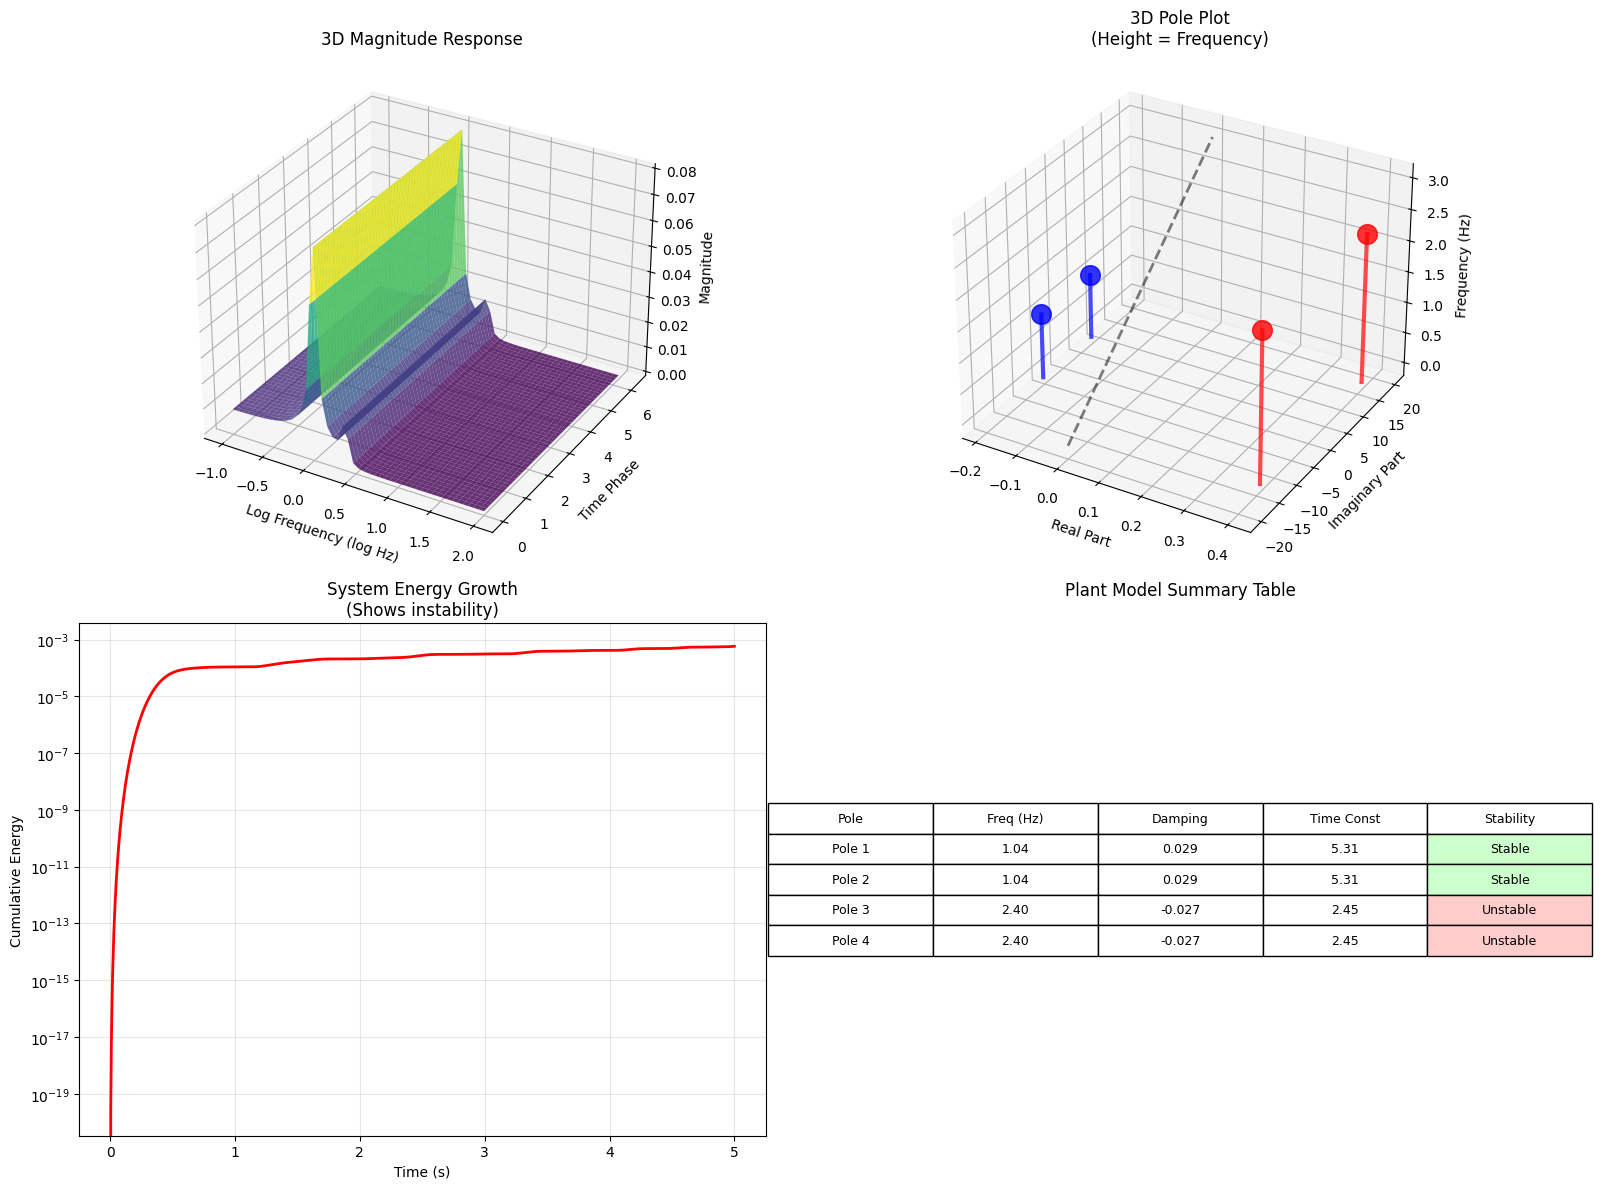


=== System Characteristics Summary ===
Plant Type: 4th order system (4 poles, 0 zeros)
Stability: Mixed (2 stable + 2 unstable poles)
Dominant instability: 2.40 Hz
Control challenge: Stabilize RHP pole while managing pendulum dynamics


In [14]:
# Alternative Visualization 4: Interactive 3D Visualization
from mpl_toolkits.mplot3d import Axes3D

# Create 3D surface plot of the system response
fig = plt.figure(figsize=(16, 12))

# 3D frequency response surface
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
freq_3d = np.logspace(-1, 2, 50)
w_3d = 2 * np.pi * freq_3d
_, h_3d = signal.freqs_zpk(zeros, poles, gain, worN=w_3d)
mag_3d = np.abs(h_3d)
phase_3d = np.angle(h_3d)

# Create meshgrid for surface
F, T = np.meshgrid(freq_3d, np.linspace(0, 2*np.pi, 50))
Z = np.outer(np.ones(50), mag_3d)

surf1 = ax1.plot_surface(np.log10(F), T, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Log Frequency (log Hz)')
ax1.set_ylabel('Time Phase')
ax1.set_zlabel('Magnitude')
ax1.set_title('3D Magnitude Response')

# 3D pole visualization with stability regions
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
poles_real = np.real(poles)
poles_imag = np.imag(poles)
poles_freq = np.abs(poles_imag) / (2 * np.pi)

# Plot stability boundary (imaginary axis)
z_boundary = np.linspace(0, 3, 100)
ax2.plot([0]*len(z_boundary), np.linspace(-20, 20, len(z_boundary)), z_boundary, 
         'k--', linewidth=2, alpha=0.5, label='Stability boundary')

# Plot poles with height representing frequency
for i, (real, imag, freq) in enumerate(zip(poles_real, poles_imag, poles_freq)):
    color = 'red' if real > 0 else 'blue'
    ax2.scatter([real], [imag], [freq], c=color, s=200, alpha=0.8)
    ax2.plot([real, real], [imag, imag], [0, freq], color=color, linewidth=3, alpha=0.7)

ax2.set_xlabel('Real Part')
ax2.set_ylabel('Imaginary Part')
ax2.set_zlabel('Frequency (Hz)')
ax2.set_title('3D Pole Plot\n(Height = Frequency)')

# Time evolution of system energy
ax3 = fig.add_subplot(2, 2, 3)
t_energy = np.linspace(0, 5, 1000)
_, y_energy = signal.step(sys, T=t_energy)
energy = np.cumsum(y_energy**2) * (t_energy[1] - t_energy[0])  # Approximate energy

ax3.plot(t_energy, energy, 'red', linewidth=2)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Cumulative Energy')
ax3.set_title('System Energy Growth\n(Shows instability)')
ax3.grid(True, alpha=0.3)
ax3.semilogy()  # Log scale to show exponential growth

# Controllability and observability analysis
ax4 = fig.add_subplot(2, 2, 4)

# Simple analysis of pole characteristics
pole_data = {
    'Frequency (Hz)': [f'{f:.2f}' for f in frequencies],
    'Damping Ratio': [f'{d:.3f}' for d in damping_ratios],
    'Time Constant (s)': [f'{1/abs(r):.2f}' if r != 0 else 'inf' for r in real_parts],
    'Stability': ['Unstable' if r > 0 else 'Stable' for r in real_parts]
}

# Create table
table_data = []
for i in range(len(poles)):
    table_data.append([f'Pole {i+1}', 
                      pole_data['Frequency (Hz)'][i],
                      pole_data['Damping Ratio'][i], 
                      pole_data['Time Constant (s)'][i],
                      pole_data['Stability'][i]])

ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=table_data, 
                  colLabels=['Pole', 'Freq (Hz)', 'Damping', 'Time Const', 'Stability'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

# Color-code stability
for i in range(len(poles)):
    if 'Unstable' in table_data[i][4]:
        table[(i+1, 4)].set_facecolor('#ffcccc')  # Light red
    else:
        table[(i+1, 4)].set_facecolor('#ccffcc')  # Light green

ax4.set_title('Plant Model Summary Table', pad=20)

plt.tight_layout()
plt.show()

print("\n=== System Characteristics Summary ===")
print(f"Plant Type: 4th order system (4 poles, 0 zeros)")
print(f"Stability: Mixed (2 stable + 2 unstable poles)")
print(f"Dominant instability: {frequencies[np.argmax(real_parts)]:.2f} Hz")
print(f"Control challenge: Stabilize RHP pole while managing pendulum dynamics")